# Dati provinciali generali

In [10]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook

# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Aggiornare con il proprio path locale
prociv_repo_dir = "/media/michele/DATA-2/Covid/prociv-covid"

Lettura dati Istat sulla popolazione

In [11]:
popolazione = pd.read_csv(os.path.join("dati_aggiuntivi", "popolazione_istat_2020.csv"))
popolazione.head()

,Zona,Popolazione
0,Italia,59641488
1,Piemonte,4311217
2,Torino,2230946
3,Vercelli,169390
4,Novara,364980


Lettura dati Protezione Civile

In [12]:
dati_province_csv = os.path.join(prociv_repo_dir, "dati-province/dpc-covid19-ita-province.csv")
andamento_province = pd.read_csv(dati_province_csv, parse_dates=[0])
andamento_province.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note,codice_nuts_1,codice_nuts_2,codice_nuts_3
0,2020-02-24 18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,NaN,NaN,NaN,NaN
1,2020-02-24 18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,NaN,NaN,NaN,NaN
2,2020-02-24 18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,NaN,NaN,NaN,NaN
3,2020-02-24 18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,NaN,NaN,NaN,NaN
4,2020-02-24 18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [13]:
andamento_province.columns

Index(['data', 'stato', 'codice_regione', 'denominazione_regione',
       'codice_provincia', 'denominazione_provincia', 'sigla_provincia', 'lat',
       'long', 'totale_casi', 'note', 'codice_nuts_1', 'codice_nuts_2',
       'codice_nuts_3'],
      dtype='object')

In [14]:
f"Aggiornato al {andamento_province['data'].max()}"

'Aggiornato al 2021-04-20 17:00:00'

## Selezione provincia

In [15]:
provincia = "Lucca"
andamento_provinciale = andamento_province[andamento_province["denominazione_provincia"] == provincia]
popolazione_provincia = int(popolazione[popolazione["Zona"] == provincia]["Popolazione"])
print(f"Provincia selezionata {provincia}, popolazione {popolazione_provincia}")

Provincia selezionata Lucca, popolazione 382543


### Smoothing e aggregazione

Sono disponibili solo i casi totali, si calcolano i nuovi positivi da qui

In [16]:
andamento_provinciale['nuovi_positivi'] = andamento_provinciale.totale_casi.diff()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Smoothing 7, periodicità settimanale per i positivi

In [17]:
andamento_provinciale['nuovi_positivi_mov_avg'] = andamento_provinciale['nuovi_positivi'].rolling(7).mean()

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Nuovi positivi settimanali per 100 000 abitanti

In [18]:
andamento_provinciale['nuovi_positivi_settimanali_centomila_abitanti'] = andamento_provinciale['nuovi_positivi'].rolling(7).sum() * 100000 / popolazione_provincia

/home/michele/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Andamento dall'inizio

<IPython.core.display.Javascript object>


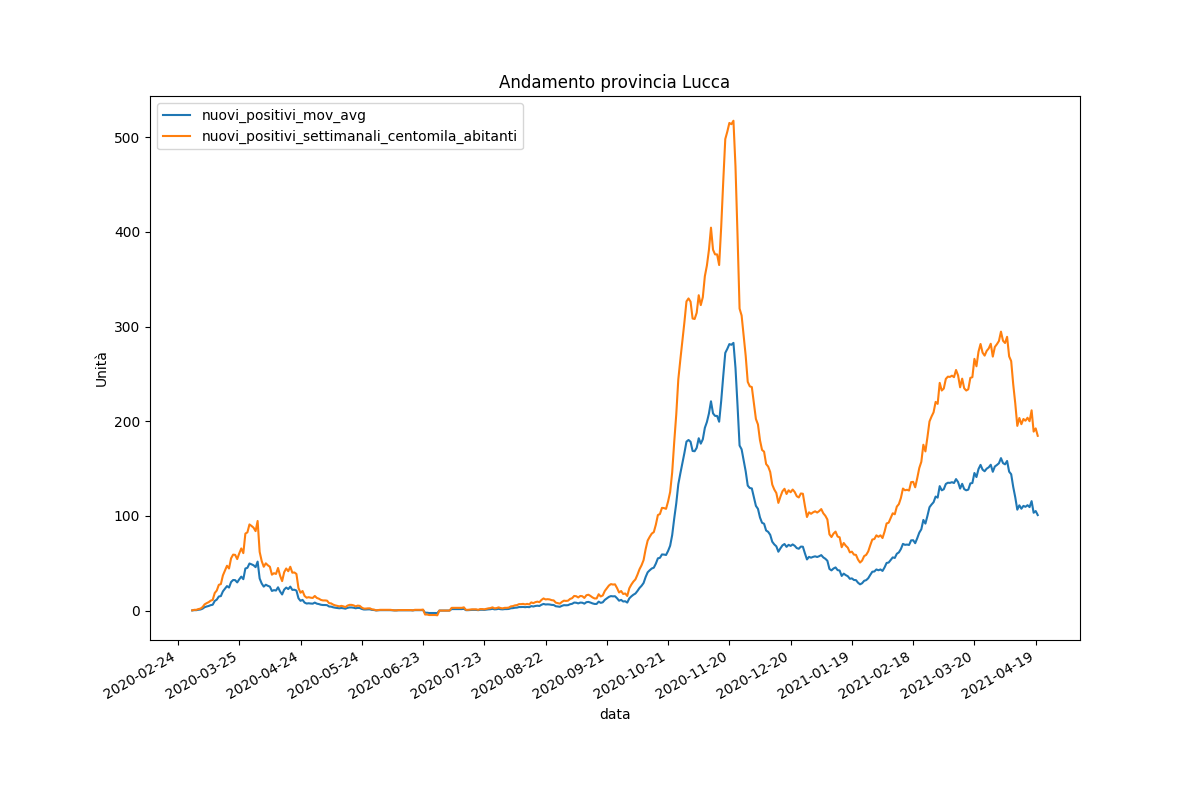

In [19]:
sampling_x = [data for ix, data in enumerate(andamento_provinciale["data"]) if ix % 30 == 0]
andamento_provinciale.plot(
    x="data",
    xticks=sampling_x,
    y=["nuovi_positivi_mov_avg", "nuovi_positivi_settimanali_centomila_abitanti"],
    title=f"Andamento provincia {provincia}",
    ylabel="Unità",
    figsize=[12, 8]
);

## Andamento con filtro data

Analisi dati a partire dalla seconda ondata dove si ha maggiore copertura e affidabilità nella raccolta dati

In [20]:
primo_ottobre = "2020-10-01 18:00:00"
inizio_zone_di_colore = "2020-11-06 18:00:00"  # DPCM 4 novembre 2020
filtro_data = primo_ottobre

### Nuovi positivi

<IPython.core.display.Javascript object>


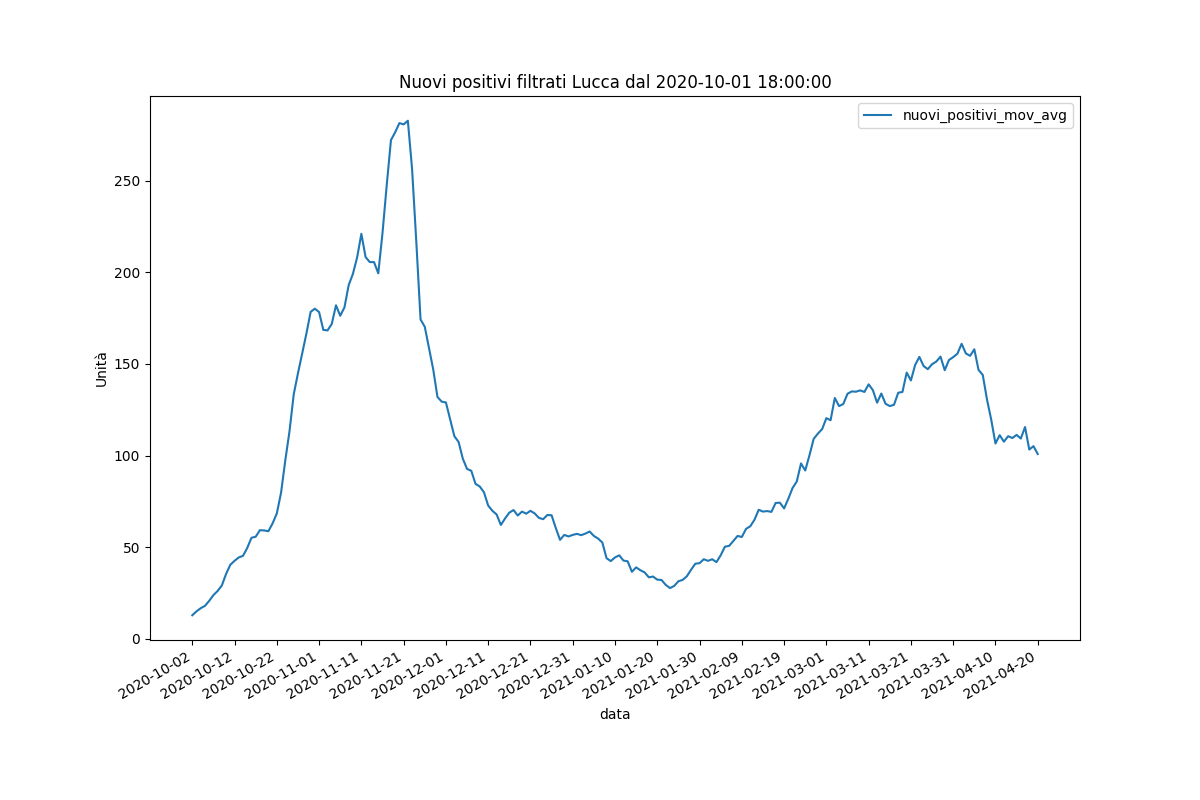

In [21]:
andamento_provinciale_filtrato = andamento_provinciale[andamento_provinciale["data"] > filtro_data]
sampling_filtrato_x = [data for ix, data in enumerate(andamento_provinciale_filtrato["data"]) if ix % 10 == 0]
andamento_provinciale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    y=["nuovi_positivi_mov_avg"],
    title=f"Nuovi positivi filtrati {provincia} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

### Nuovi positivi settimanali per centomila abitanti

<IPython.core.display.Javascript object>


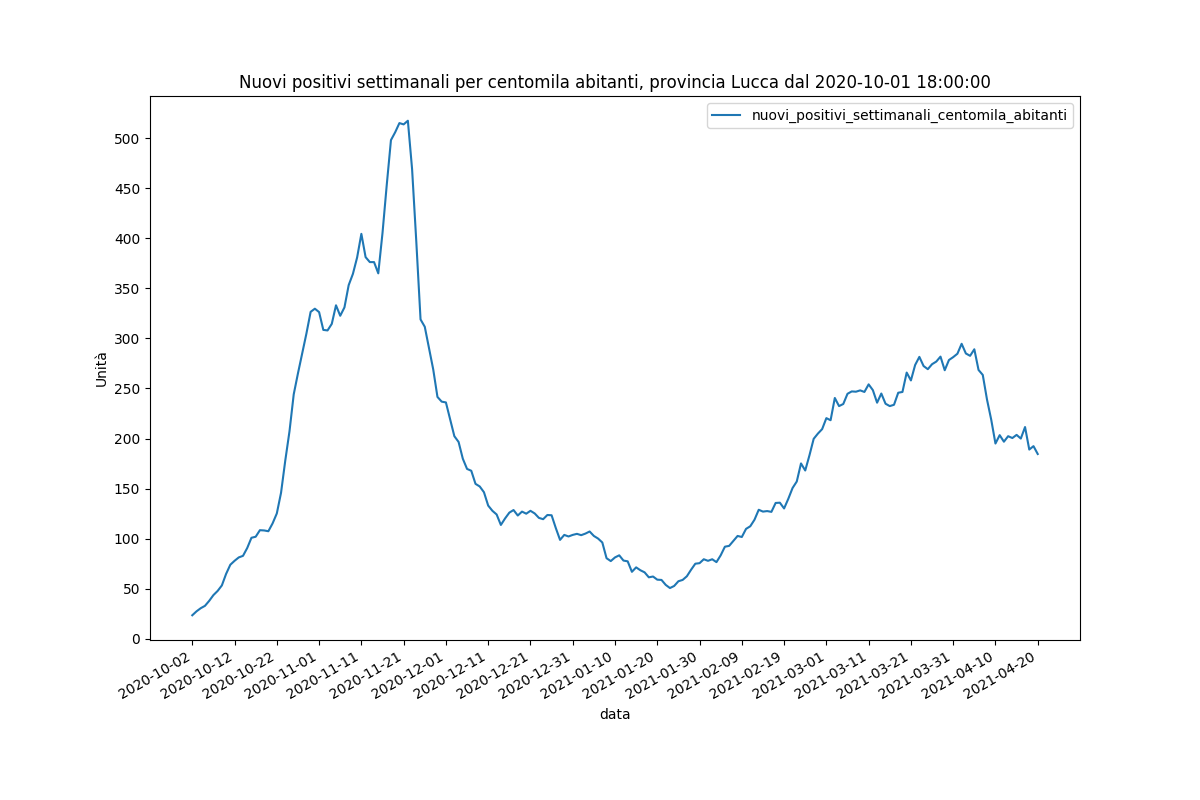

In [22]:
sampling_y = range(0, int(andamento_provinciale_filtrato["nuovi_positivi_settimanali_centomila_abitanti"].max()), 50)
andamento_provinciale_filtrato.plot(
    x="data",
    xticks=sampling_filtrato_x,
    yticks=sampling_y,
    y=["nuovi_positivi_settimanali_centomila_abitanti"],
    title=f"Nuovi positivi settimanali per centomila abitanti, provincia {provincia} dal {filtro_data}",
    ylabel="Unità",
    figsize=[12, 8]
);

TODO:
- Colorare lo sfondo in orizzontale in base alle soglie rispetto all'indicatore / tracciare linee orizzontale in prossimità dei punti di cambio colore